In [30]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# import plt
import matplotlib.pyplot as plt


In [31]:
# Set the directory containing the images
input_directory = "data"

# add to grey
transform = transforms.Compose([transforms.Resize(100),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder(input_directory, transform=transform)

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))



# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 192
Test set size: 64


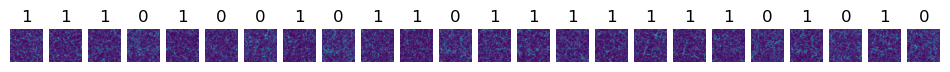

In [32]:
# show the images from the first batch with their labels
for images, labels in train_loader:
    # big figure
    fig, ax = plt.subplots(1, len(images), figsize=(12, 12))
    for i, image in enumerate(images):
        ax[i].imshow(image[0])
        ax[i].set_title(labels[i].item())
        ax[i].axis('off')
    break

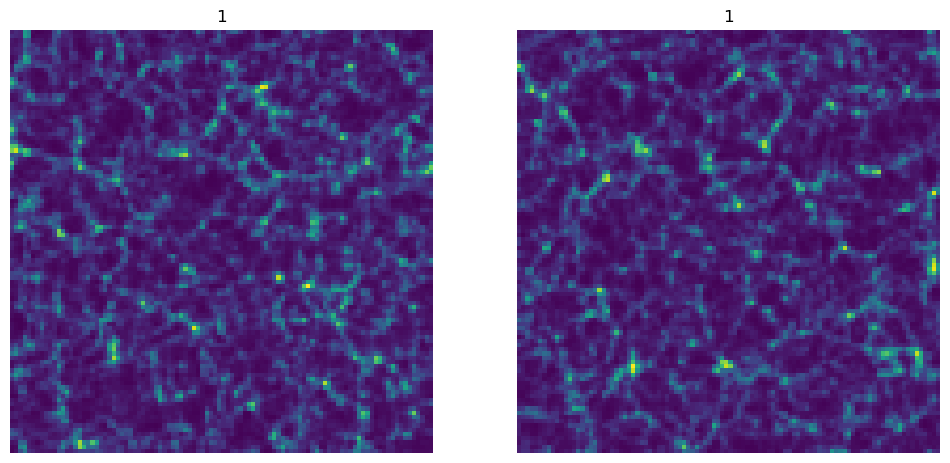

In [33]:
# show jyst two images
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[0][0])
ax[0].set_title(labels[0].item())
ax[0].axis('off')
ax[1].imshow(images[1][0])
ax[1].set_title(labels[1].item())
ax[1].axis('off')
plt.show()

In [34]:
# get dimension
print(images[0].shape)

torch.Size([1, 100, 100])


In [35]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*25*25, latent_dim)
        self.fc2 = torch.nn.Linear(64*25*25, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*25*25),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 25, 25)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [36]:
# define the model
latent_dim = 2
model = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
# test the model
reconst, mu, logvar = model(images)

In [38]:
# train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(train_loader.dataset)}')

Epoch 0, Loss 4899.317952473958
Epoch 1, Loss 3723.6287434895835
Epoch 2, Loss 3600.2157389322915
Epoch 3, Loss 3563.7882080078125
Epoch 4, Loss 3543.5701904296875
Epoch 5, Loss 3531.393310546875
Epoch 6, Loss 3520.2518310546875
Epoch 7, Loss 3513.3056640625
Epoch 8, Loss 3506.267578125
Epoch 9, Loss 3501.3704427083335
Epoch 10, Loss 3496.402384440104
Epoch 11, Loss 3491.2252197265625
Epoch 12, Loss 3486.526123046875
Epoch 13, Loss 3482.750447591146
Epoch 14, Loss 3479.8467610677085
Epoch 15, Loss 3478.3653971354165
Epoch 16, Loss 3474.7852376302085
Epoch 17, Loss 3472.779012044271
Epoch 18, Loss 3470.397908528646
Epoch 19, Loss 3469.197713216146
Epoch 20, Loss 3467.6876627604165
Epoch 21, Loss 3466.3138020833335
Epoch 22, Loss 3465.4886067708335
Epoch 23, Loss 3463.7200927734375
Epoch 24, Loss 3462.192097981771
Epoch 25, Loss 3461.2976888020835
Epoch 26, Loss 3460.9340006510415
Epoch 27, Loss 3459.7762858072915
Epoch 28, Loss 3458.938232421875
Epoch 29, Loss 3458.2227376302085
Epoch 3

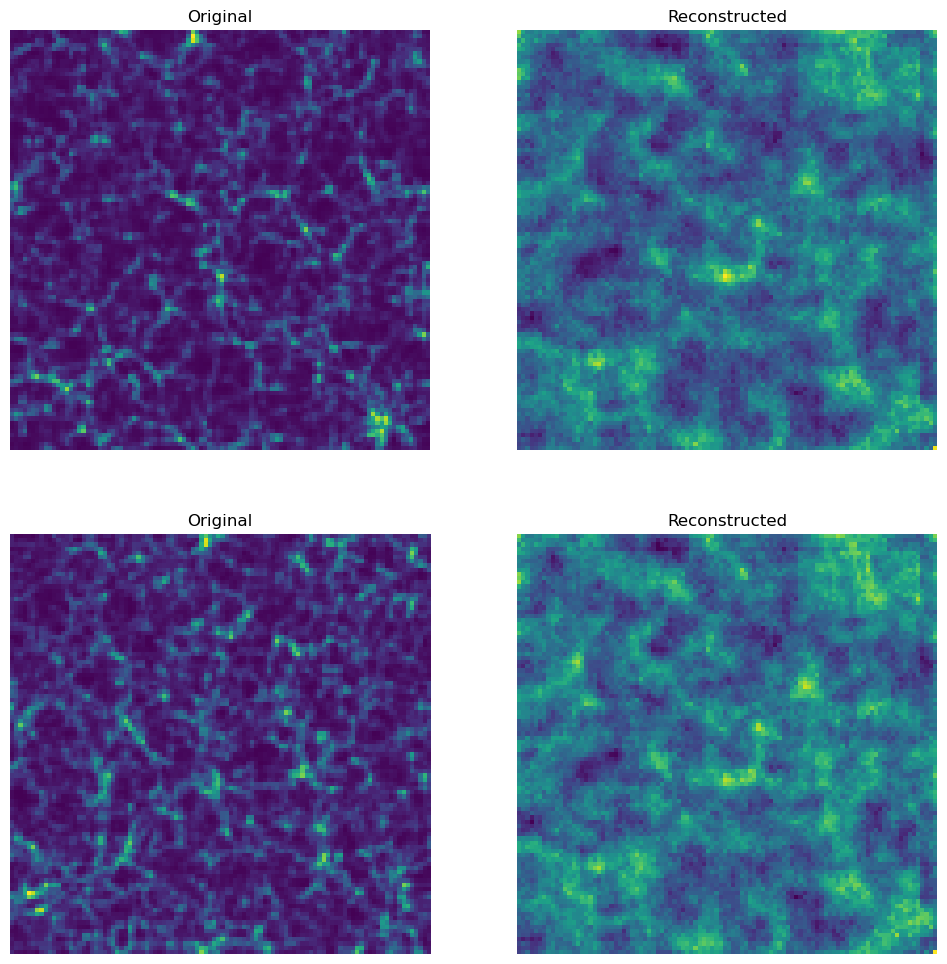

In [39]:
# show original and reconstructed images of the first two images in the test set
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        recon_images, _, _ = model(images)
        plt.figure(figsize=(12, 12))
        for i in range(2):
            plt.subplot(2, 2, i*2+1)
            plt.imshow(images[i][0])
            # add labels and title
            plt.title('Original')
            plt.axis('off')
            plt.subplot(2, 2, i*2+2)
            plt.imshow(recon_images[i][0])
            # add labels and title
            plt.title('Reconstructed')
            plt.axis('off')
        break

In [40]:
# plot the latent space of the train set

model.eval()
latent_vectors = []
categories = [] 

for images, labels in train_loader:
    _, mu, _ = model(images)
    latent_vectors.append(mu.detach().numpy())
    categories.append(labels.detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
categories = np.concatenate(categories, axis=0)

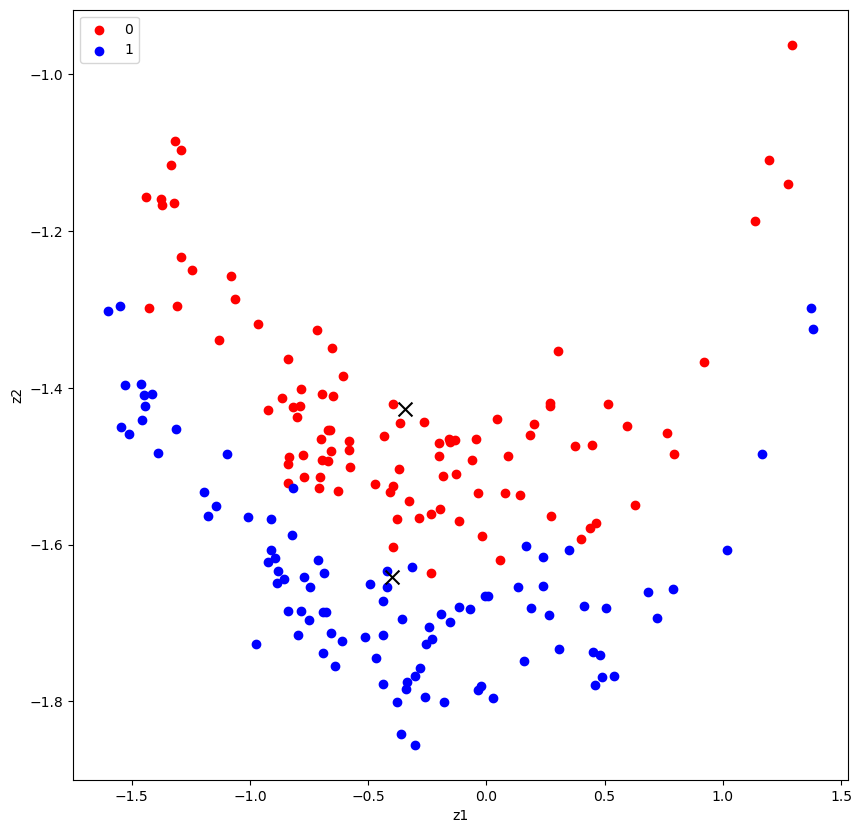

In [41]:
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors[categories==0, 0], latent_vectors[categories==0, 1], label='0', color='red')
plt.scatter(latent_vectors[categories==1, 0], latent_vectors[categories==1, 1], label='1', color='blue')

# get the mean on 1 and 9
mean_0 = np.mean(latent_vectors[categories==0], axis=0)
mean_1 = np.mean(latent_vectors[categories==1], axis=0)

plt.scatter(mean_0[0], mean_0[1], color='black', marker='x', s=100)
plt.scatter(mean_1[0], mean_1[1], color='black', marker='x', s=100)

# add labels
plt.xlabel('z1')
plt.ylabel('z2')

# add legend
plt.legend()


In [42]:
# get the mean of the latent vectors for the two categories
mean_latent_vectors = np.zeros((len(class_labels), latent_dim))
std_latent_vectors = np.zeros((len(class_labels), latent_dim))

for i in range(len(class_labels)):
    mean_latent_vectors[i] = np.mean(latent_vectors[categories == i], axis=0)
    std_latent_vectors[i] = np.std(latent_vectors[categories == i], axis=0)
    # print the mean and std
    print(f'Category {class_labels[i]}')
    print(f'Mean: {mean_latent_vectors[i]}')
    print(f'Std: {std_latent_vectors[i]}')


Category mu0_-1
Mean: [-0.34449419 -1.42673254]
Std: [0.64784086 0.13678083]
Category mu0_1
Mean: [-0.40026519 -1.64170384]
Std: [0.68997705 0.12697522]


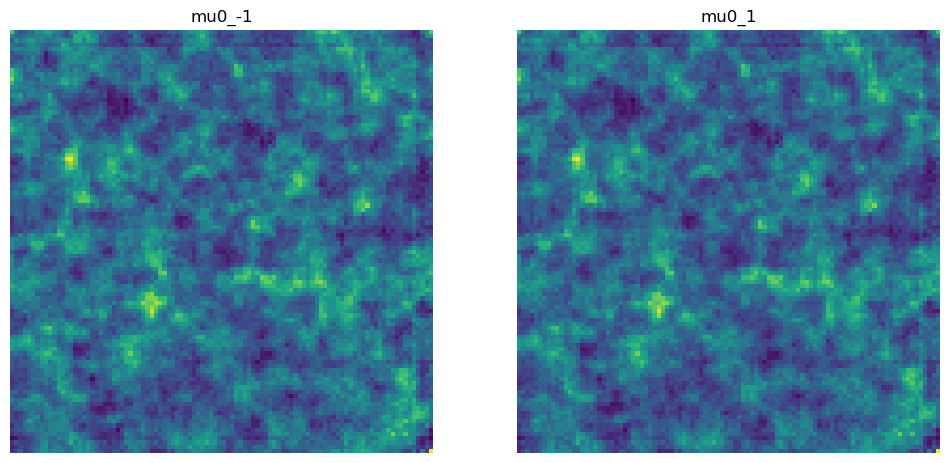

In [43]:
# generate image from the mean latent vector, there are onlty two categories
model.eval()

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
with torch.no_grad():
    z = torch.tensor(mean_latent_vectors[0]).float()
    z = z.unsqueeze(0)
    recon_image = model.decoder(z)
    plt.imshow(recon_image[0][0])
    plt.title(class_labels[0])
    plt.axis('off')
plt.subplot(1, 2, 2)
with torch.no_grad():
    z = torch.tensor(mean_latent_vectors[1]).float()
    z = z.unsqueeze(0)
    recon_image = model.decoder(z)
    plt.imshow(recon_image[0][0])
    plt.title(class_labels[1])
    plt.axis('off')

In [44]:
# define the model1
latent_dim = 2
model1 = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

# test the model1
reconst, mu, logvar = model1(images)
# train the model1
num_epochs = 300
for epoch in range(num_epochs):
    model1.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model1(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(train_loader.dataset)}')

Epoch 0, Loss 5247.134847005208
Epoch 1, Loss 3867.7864583333335
Epoch 2, Loss 3705.710164388021
Epoch 3, Loss 3620.4632568359375
Epoch 4, Loss 3578.746541341146
Epoch 5, Loss 3558.154500325521
Epoch 6, Loss 3543.8705240885415
Epoch 7, Loss 3532.5047607421875
Epoch 8, Loss 3520.5609130859375
Epoch 9, Loss 3512.7858072916665
Epoch 10, Loss 3505.723347981771
Epoch 11, Loss 3498.963582356771
Epoch 12, Loss 3493.639200846354
Epoch 13, Loss 3488.7045084635415
Epoch 14, Loss 3484.843302408854
Epoch 15, Loss 3481.3531087239585
Epoch 16, Loss 3478.302937825521
Epoch 17, Loss 3475.53173828125
Epoch 18, Loss 3473.3526204427085
Epoch 19, Loss 3471.4144287109375
Epoch 20, Loss 3469.4993489583335
Epoch 21, Loss 3467.9408365885415
Epoch 22, Loss 3466.7606201171875
Epoch 23, Loss 3465.420125325521
Epoch 24, Loss 3464.3181966145835
Epoch 25, Loss 3463.1900634765625
Epoch 26, Loss 3462.609903971354
Epoch 27, Loss 3461.9183349609375
Epoch 28, Loss 3460.638142903646
Epoch 29, Loss 3459.955037434896
Epoch

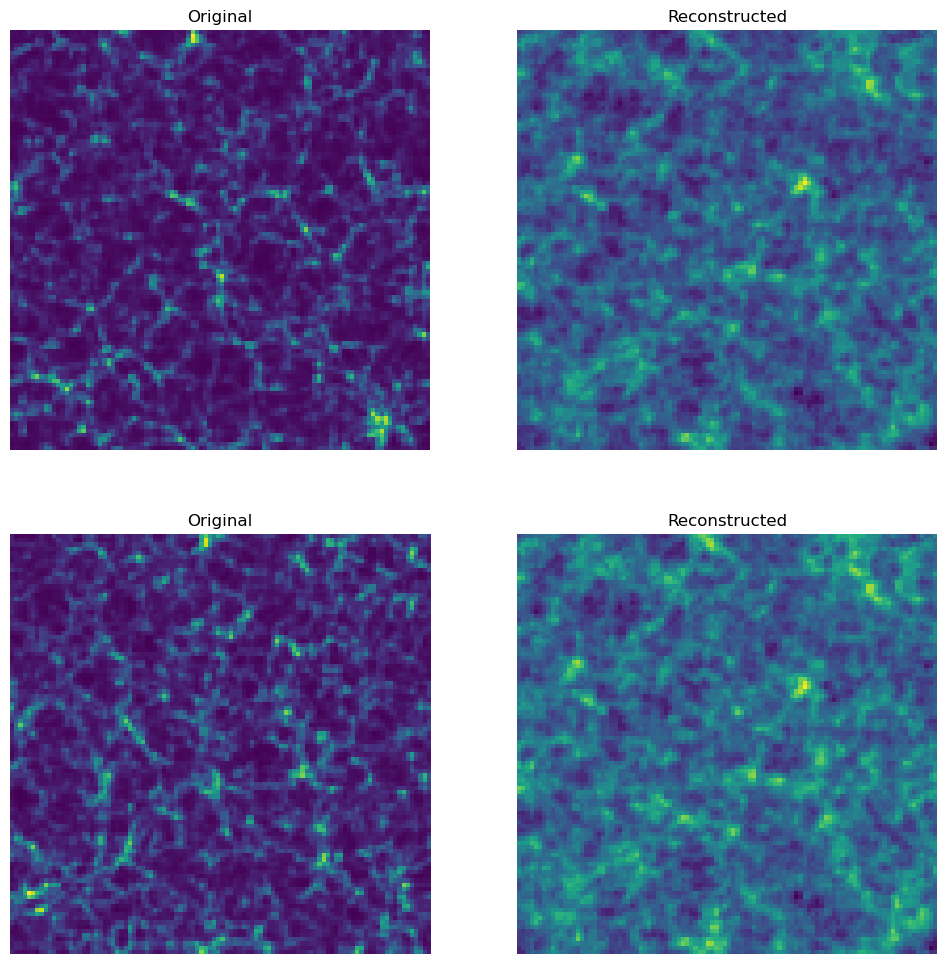

In [45]:
# show original and reconstructed images of the first two images in the test set
model1.eval()
with torch.no_grad():
    for images, _ in test_loader:
        recon_images, _, _ = model1(images)
        plt.figure(figsize=(12, 12))
        for i in range(2):
            plt.subplot(2, 2, i*2+1)
            plt.imshow(images[i][0])
            # add labels and title
            plt.title('Original')
            plt.axis('off')
            plt.subplot(2, 2, i*2+2)
            plt.imshow(recon_images[i][0])
            # add labels and title
            plt.title('Reconstructed')
            plt.axis('off')
        break

In [ ]:
def binavg(pk,k_min, k_max, kgrid,nkbins):
    '''
    Bin averaging for the powerspectrum calculations
    '''
    kgrid[0,0] = 1.0
    ikbin = np.digitize(kgrid,np.linspace(k_min,k_max,nkbins+1),right=False)

    nmodes,pkavg,kmean = np.zeros(nkbins,dtype=int),np.full(nkbins,0.),np.full(nkbins,0.)
    for ik in range(nkbins):
        nmodes[ik] = int(np.sum(np.array([ikbin == ik+1])))
        if (nmodes[ik] > 0):
            pkavg[ik] = np.mean(pk[ikbin == ik+1])
            kmean[ik] = np.mean(kgrid[ikbin == ik+1])

    return pkavg, nmodes, kmean

def PS(density_field):
    data = (anti_s2(denorm(density_field)))
    ## Defining the grid in 2-D:
    kx = 2. * np.pi * np.fft.fftfreq(128, d=1.)
    ky = 2. * np.pi * np.fft.fftfreq(128, d=1.)
    kgrid = np.sqrt(kx[:,np.newaxis]**2.0 + kx[np.newaxis,:]**2.0)

    k_min = 0.0
    k_max = 3.14   ## k_max = 128*pi/512 ##the Nyquist frequency calculated using the number of pixes * pi/physical length of the array
    nkbins = 16    ## to find and estimate for this calculate the fundamental frequency kf = 2*pi/512^1/3
                  ## --> in our case kf = 2*pi/Area_box^{1/2}. And then kmax-kmin/kf ~ nkbins

  ## For data1:
    delta_r = data
    delta_k = np.fft.fftn(delta_r)
    pk = np.real(delta_k * np.conj(delta_k))
    pkavg, nmodes, kmean = binavg(pk, k_min, k_max, kgrid, nkbins)
    return np.column_stack((kmean, pkavg))

def calculate_mean_PS(PS_matrix):
    pk_matrix = PS_matrix[:, :, 1]  # Extract the second value of the third dimension
    pk_mean = np.mean(pk_matrix, axis=0)
    k = PS_matrix[0, :, 0]  # Extract the first column of the first row
    mean_PS = np.column_stack((k, pk_mean))
    return mean_PS


def PS_loss(model_VAE,test_images,train_images):
    recon_images, _, _ = model_VAE(test_images)
    recon_images = recon_images.squeeze()
    train_images = train_images.squeeze()
    PS_recon = np.array([PS(image) for image in recon_images])
    PS_train = np.array([PS(image) for image in train_images])
    mean_train_PS = calculate_mean_PS(PS_train)
    mean_recon_PS = calculate_mean_PS(PS_recon)

    return np.mean(np.square(mean_recon_PS[:,1] - mean_train_PS[:,1]))